In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation

### Load in Data and Clean:

In [2]:
# Load historical data from file:
df = pd.read_csv('eth_historical_data.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)
# Pull just the value fields:
df = df[['price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'trades_count']]
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
time_period_start,,,,,,
06-24-2019 17:00,308.84,313.09,308.84,311.24,3454.712211,460
06-24-2019 17:30,311.23,311.70,308.12,308.80,511.260554,100
06-24-2019 18:00,308.89,310.31,308.24,308.91,1355.438085,145
06-24-2019 18:30,308.81,310.44,308.81,310.44,129.936307,134
06-24-2019 19:00,310.75,312.40,309.79,310.43,2269.709662,410


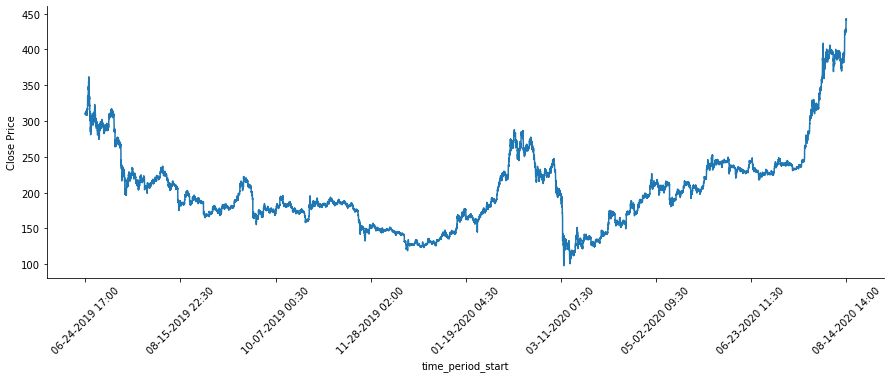

In [3]:
# Plot the closing prices just as a reference:
df['price_close'].plot(figsize=(15,5))
plt.ylabel('Close Price')
plt.xticks(rotation=45)
sns.despine()
plt.show()

### Prepare Data for Modeling

In [49]:
# Split into training and test sets
def split_data(data, training_size=0.8):
    return np.array(data[:int(training_size*len(data))]), np.array(data[int(training_size*len(data)):])

# convert history into inputs and outputs
def to_supervised(data, n_input, n_out):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance 
        if out_end <= len(data):
            X.append((data[in_start:in_end, :]/data[in_start:in_end, :][0]) - 1)
            y.append((data[in_end:out_end, 3]/data[in_start, 3]) - 1)
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y).reshape(-1)

In [50]:
n_input = 3
n_out = 1

# scaled_df = minMax_Scaler(df)
train_set, test_set = split_data(df)
X_train, y_train = to_supervised(train_set, n_input, n_out)
X_test, y_test = to_supervised(test_set, n_input, n_out)

### Build Model

In [52]:
neurons = 1024               # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 12

def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=n_out))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae']) 
    model.summary()
    return model

In [53]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
model = build_model(X_train, n_out, neurons=neurons)
fit_model = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 3, 1024)           4222976   
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 1024)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1024)             

In [64]:
def show_plot(data):
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
    ax1.set_ylabel('Closing Price ($)',fontsize=12)
    ax2.set_ylabel('Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
    ax2.set_yticklabels(range(10))
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(data['time_close'],data['price_close'])
    ax2.bar(data['time_close'].values, data['volume_traded'].values)
    fig.tight_layout()
    plt.show()
    
def date_labels(market_data):
    last_date = market_data.iloc[0, 0]
    date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
    return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_train, y_test, n_input):
    plt.figure(figsize=(25, 20))
    plt.subplot(311)
    plt.plot(history.epoch, history.history['loss'], )
    plt.plot(history.epoch, history.history['val_loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title(' Model Loss')
    plt.legend(['Training', 'Test'])

    plt.subplot(312)
    plt.plot(Y_train)
    plt.plot(model.predict(X_train))
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title(' Single Point Price Prediction on Training Set')
    plt.legend(['Actual','Predicted'])

    ax1 = plt.subplot(313)
    plt.plot(y_test[n_input:].tolist())
    plt.plot(((np.transpose(model.predict(X_test)) + 1) * y_test[:-n_input])[0])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title(' Single Point Price Prediction on Test Set')
    plt.legend(['Actual','Predicted'])

In [71]:
y_test

array([-0.00198547, -0.00178943, -0.0049629 , ...,  0.00106448,
        0.00547031,  0.00015876])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

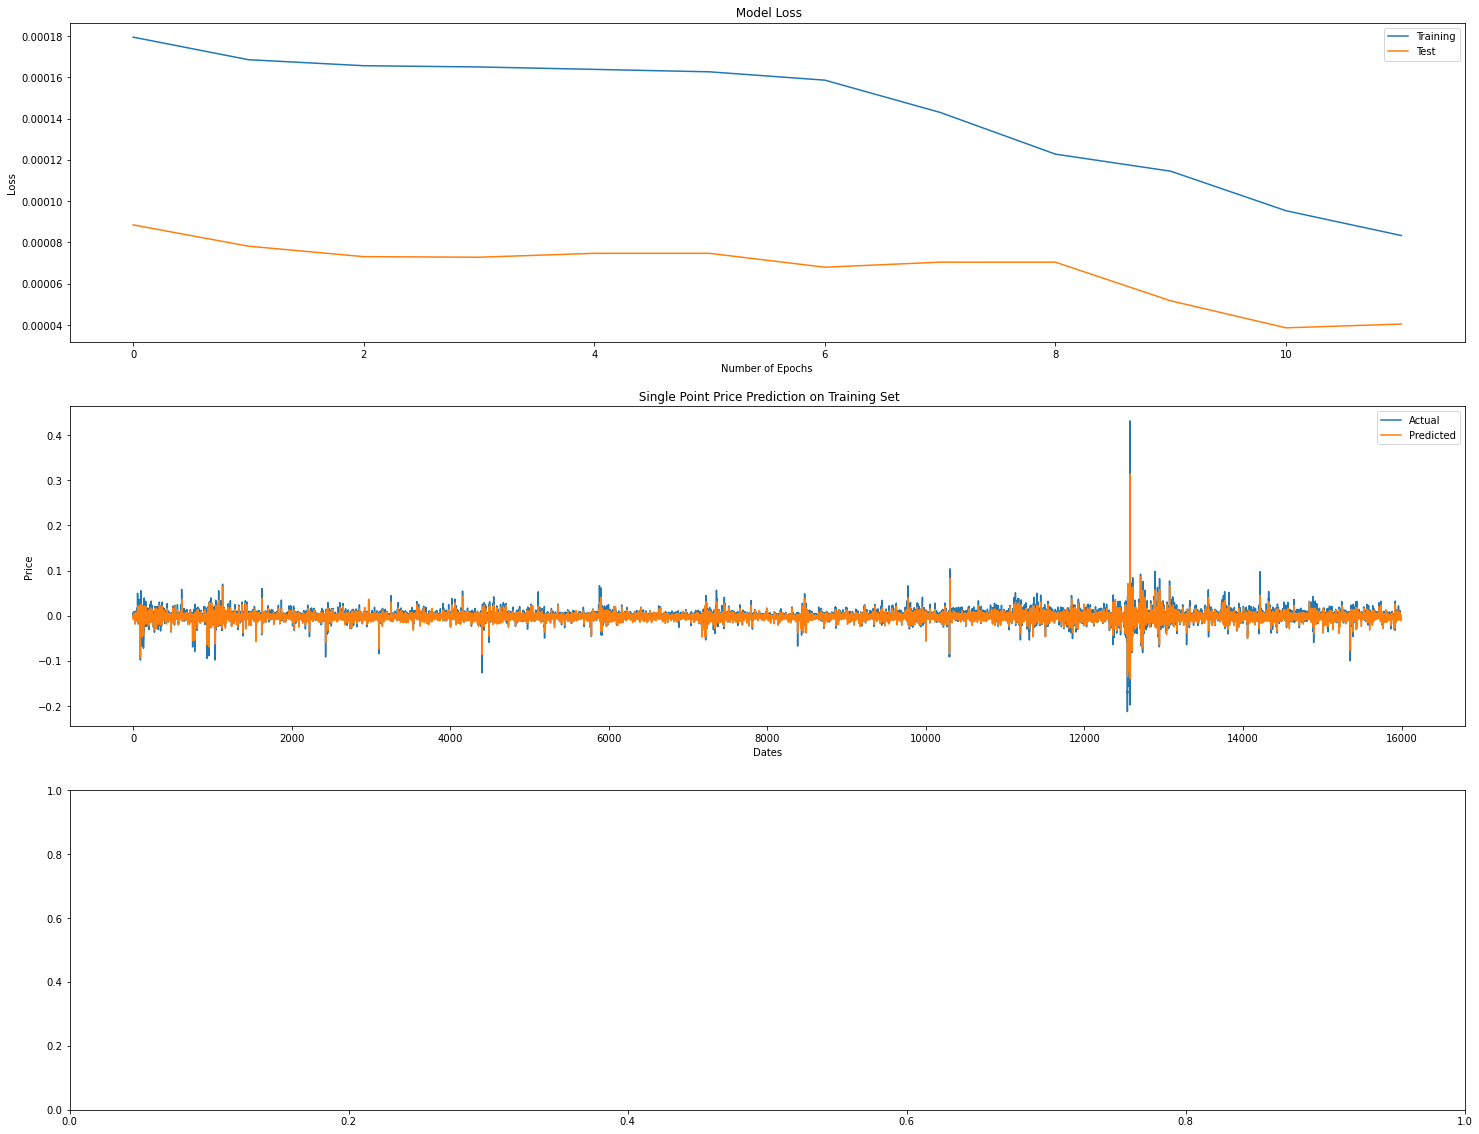

In [63]:
plot_results(fit_model, model, y_train, y_test, n_input)